,Layer (1=closest to input),Grad norm (Sigmoid),Grad norm (ReLU)
0,1,4.087997e-12,8.471721
1,2,1.125797e-11,10.569304
2,3,5.215802e-11,9.787164
3,4,2.552220e-10,9.815130
4,5,1.244765e-09,13.017099
5,6,5.292657e-09,10.736772
6,7,1.900178e-08,10.749751
7,8,7.608500e-08,10.338950
8,9,2.926248e-07,10.190322
9,10,1.270259e-06,7.949375


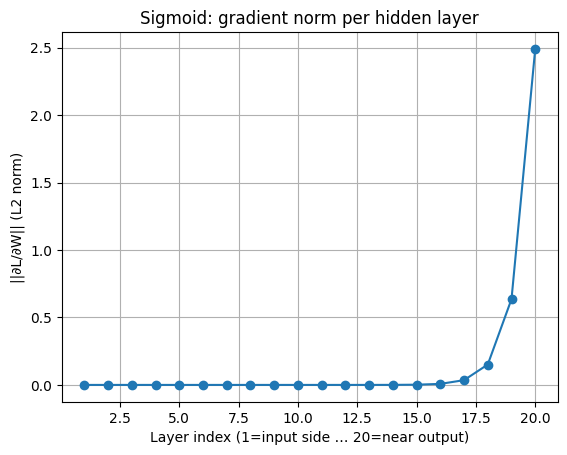

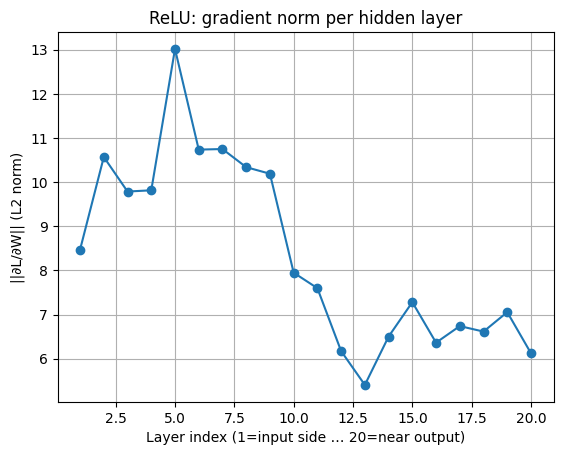

Output-layer gradient norms:
  Sigmoid output-layer ||∂L/∂W_out|| = 1.0508e+01
  ReLU    output-layer ||∂L/∂W_out|| = 6.1715e+00

Observación rápida: Sigmoid muestra degradación notable del gradiente hacia las capas cercanas a la entrada.


In [2]:
# Vanishing vs. non-vanishing gradients demo (Sigmoid vs ReLU)
# This notebook builds two deep MLPs (same depth/width), one with Sigmoid and one with ReLU.
# It runs a single forward/backward pass and records the gradient norm of each layer's weights.
# You'll see how gradients shrink in Sigmoid networks compared to ReLU.

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple
import pandas as pd


np.random.seed(42)

# -----------------------------
# Helper: activations & derivatives
# -----------------------------
def sigmoid(x: np.ndarray) -> np.ndarray:
    # numerically stable sigmoid
    out = np.empty_like(x)
    pos = x >= 0
    neg = ~pos
    out[pos] = 1 / (1 + np.exp(-x[pos]))
    expx = np.exp(x[neg])
    out[neg] = expx / (1 + expx)
    return out

def d_sigmoid(x: np.ndarray) -> np.ndarray:
    s = sigmoid(x)
    return s * (1 - s)

def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

def d_relu(x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(x.dtype)

# -----------------------------
# MLP builder (numpy)
# -----------------------------
def init_weights(n_in: int, n_hidden: int, n_layers: int, n_out: int, activation: str):
    """Return list of (W, b) for hidden layers and (W_out, b_out) for output layer."""
    Ws: List[np.ndarray] = []
    bs: List[np.ndarray] = []

    # Choose initialization matched to activation
    if activation.lower() == "sigmoid":
        # Xavier/Glorot for sigmoid: var = 2/(fan_in+fan_out)
        def glorot(fan_in, fan_out):
            limit = np.sqrt(6.0 / (fan_in + fan_out))
            return np.random.uniform(-limit, limit, size=(fan_out, fan_in))
        act = sigmoid
        dact = d_sigmoid
        init_fn = glorot
    elif activation.lower() == "relu":
        # He initialization for ReLU: var = 2/fan_in
        def he(fan_in, fan_out):
            std = np.sqrt(2.0 / fan_in)
            return np.random.randn(fan_out, fan_in) * std
        act = relu
        dact = d_relu
        init_fn = he
    else:
        raise ValueError("Unsupported activation")

    # First hidden layer
    fan_in, fan_out = n_in, n_hidden
    Ws.append(init_fn(fan_in, fan_out))
    bs.append(np.zeros((fan_out, 1)))

    # Remaining hidden layers
    for _ in range(n_layers - 1):
        fan_in, fan_out = n_hidden, n_hidden
        Ws.append(init_fn(fan_in, fan_out))
        bs.append(np.zeros((fan_out, 1)))

    # Output layer (linear to scalar)
    W_out = np.random.randn(n_out, n_hidden) * (np.sqrt(2.0 / n_hidden) if activation.lower()=="relu" else np.sqrt(1.0 / n_hidden))
    b_out = np.zeros((n_out, 1))

    return Ws, bs, W_out, b_out, act, dact

def forward_pass(x: np.ndarray, Ws: List[np.ndarray], bs: List[np.ndarray], W_out: np.ndarray, b_out: np.ndarray, act: Callable):
    """Return lists of z and a (pre/post activations), and output y_hat (scalar)."""
    a = x
    As = [a]   # include input as A0
    Zs = []
    for W, b in zip(Ws, bs):
        z = W @ a + b     # (hidden, 1)
        a = act(z)        # (hidden, 1)
        Zs.append(z)
        As.append(a)
    y_hat = W_out @ a + b_out  # (1,1)
    return Zs, As, y_hat

def backward_pass(target: float, Zs: List[np.ndarray], As: List[np.ndarray], Ws: List[np.ndarray],
                  W_out: np.ndarray, b_out: np.ndarray, dact: Callable) -> Tuple[List[np.ndarray], np.ndarray]:
    """
    Compute gradients dL/dW for each hidden layer and output layer.
    Loss: 0.5 * (y_hat - y)^2
    """
    y = np.array([[target]], dtype=float)
    y_hat = W_out @ As[-1] + b_out
    dL_dy = y_hat - y  # (1,1)

    # Output layer grads
    dL_dW_out = dL_dy @ As[-1].T  # (1, hidden)
    dL_db_out = dL_dy             # (1,1)
    dL_da = W_out.T @ dL_dy       # (hidden,1)

    # Hidden layers (backwards)
    dW_list = []
    for l in reversed(range(len(Ws))):
        dz = dL_da * dact(Zs[l])            # (hidden,1)
        dW = dz @ As[l].T                   # (hidden, prev)
        db = dz
        dW_list.append(dW)
        if l > 0:
            dL_da = Ws[l].T @ dz            # (hidden,1)
        else:
            dL_da = Ws[l].T @ dz            # (n_in,1) – not used further

    dW_list.reverse()  # from first hidden to last
    return dW_list, dL_dW_out

def run_experiment(depth=20, width=128, activation="sigmoid"):
    n_in = 100
    n_out = 1
    x = np.random.randn(n_in, 1)
    target = float(np.random.randn())

    Ws, bs, W_out, b_out, act, dact = init_weights(n_in, width, depth, n_out, activation)
    Zs, As, y_hat = forward_pass(x, Ws, bs, W_out, b_out, act)
    dW_list, dW_out = backward_pass(target, Zs, As, Ws, W_out, b_out, dact)

    # Collect gradient norms for each hidden layer
    grad_norms = [np.linalg.norm(g) for g in dW_list]
    return grad_norms, np.linalg.norm(dW_out)

# -----------------------------
# Run both variants
# -----------------------------
DEPTH = 20
WIDTH = 128

sig_grads, sig_out_grad = run_experiment(depth=DEPTH, width=WIDTH, activation="sigmoid")
relu_grads, relu_out_grad = run_experiment(depth=DEPTH, width=WIDTH, activation="relu")

# Prepare DataFrame
df = pd.DataFrame({
    "Layer (1=closest to input)": list(range(1, DEPTH+1)),
    "Grad norm (Sigmoid)": sig_grads,
    "Grad norm (ReLU)": relu_grads
})

display(df)

# -----------------------------
# Plot 1: Sigmoid gradient norms per layer
# -----------------------------
plt.figure()
plt.plot(range(1, DEPTH+1), sig_grads, marker='o')
plt.title("Sigmoid: gradient norm per hidden layer")
plt.xlabel("Layer index (1=input side … 20=near output)")
plt.ylabel("||∂L/∂W|| (L2 norm)")
plt.grid(True)
plt.show()

# -----------------------------
# Plot 2: ReLU gradient norms per layer
# -----------------------------
plt.figure()
plt.plot(range(1, DEPTH+1), relu_grads, marker='o')
plt.title("ReLU: gradient norm per hidden layer")
plt.xlabel("Layer index (1=input side … 20=near output)")
plt.ylabel("||∂L/∂W|| (L2 norm)")
plt.grid(True)
plt.show()

# -----------------------------
# Print small textual summary
# -----------------------------
print("Output-layer gradient norms:")
print(f"  Sigmoid output-layer ||∂L/∂W_out|| = {sig_out_grad:.4e}")
print(f"  ReLU    output-layer ||∂L/∂W_out|| = {relu_out_grad:.4e}")

# Brief qualitative observation
if df["Grad norm (Sigmoid)"].iloc[0] < df["Grad norm (Sigmoid)"].iloc[-1] * 0.5:
    note = "Sigmoid muestra degradación notable del gradiente hacia las capas cercanas a la entrada."
else:
    note = "Con estos parámetros, la degradación de Sigmoid es menos pronunciada, pero suele aparecer al aumentar profundidad o cambiar inicialización."

print("\nObservación rápida:", note)